# Behavioral Cloning 


In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import collections
import cv2 #this needs to be imported before TF!!
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from six.moves import map
import re
from datetime import datetime

%matplotlib inline

- Smooth consecutive images
- Class imbalance
- Crop images on Keras
- Keras lambda layers to normalize images
- Flip images (for sequences. adjust steering as well)
- Output smoothing - smooth the ground truth
- Random shift and rotation (end-to-end)
- Batch normalization / Dropout
- Hough Lines - yellow and red lines must contain information!
- RNNs
- Save the model

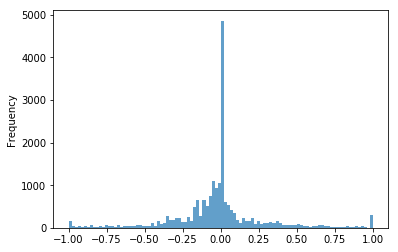

In [22]:
driving_log = pd.read_csv("driving_log.csv",header=None)
driving_log.columns = ['center_image','left_image','right_image','steering_angle','throttle','break','speed']
driving_log.steering_angle.plot.hist(alpha=0.7,bins=100)

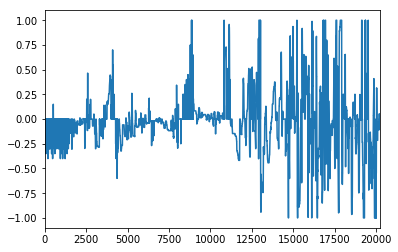

In [23]:
driving_log.steering_angle.plot()

In [35]:
driving_log.center_image.head()[0]

'/Users/denizzorlu/sdc/IMG/center_2017_02_13_19_16_42_158.jpg'

In [75]:
# The little module retrieves the time the image is captured and the delta between consecutive images 
def compute_timestamp(df):
    conv = "%Y%m%d%H%M%S%f"
    r = r'(.*)(center_)(.*)(.jpg)'
    _res = df.center_image.str.match(r)
    dt = [datetime.strptime(r[2].replace("_",""),conv) for r in _res]
    df['record_time'] = dt
    df['record_diff'] = df['record_time'].diff(1)
    return df
driving_log = compute_timestamp(driving_log)

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: In future versions of pandas, match will change to always return a bool indexer.


In [76]:
driving_log.head()

,center_image,left_image,right_image,steering_angle,throttle,break,speed,record_time,record_diff
0,/Users/denizzorlu/sdc/IMG/center_2017_02_13_19...,/Users/denizzorlu/sdc/IMG/left_2017_02_13_19_1...,/Users/denizzorlu/sdc/IMG/right_2017_02_13_19_...,0.0,0.0,0.0,0.000009,2017-02-13 19:16:42.158,NaT
1,/Users/denizzorlu/sdc/IMG/center_2017_02_13_19...,/Users/denizzorlu/sdc/IMG/left_2017_02_13_19_1...,/Users/denizzorlu/sdc/IMG/right_2017_02_13_19_...,0.0,0.0,0.0,0.000005,2017-02-13 19:16:42.255,00:00:00.097000
2,/Users/denizzorlu/sdc/IMG/center_2017_02_13_19...,/Users/denizzorlu/sdc/IMG/left_2017_02_13_19_1...,/Users/denizzorlu/sdc/IMG/right_2017_02_13_19_...,0.0,0.0,0.0,0.000002,2017-02-13 19:16:42.323,00:00:00.068000
3,/Users/denizzorlu/sdc/IMG/center_2017_02_13_19...,/Users/denizzorlu/sdc/IMG/left_2017_02_13_19_1...,/Users/denizzorlu/sdc/IMG/right_2017_02_13_19_...,0.0,0.0,0.0,0.000012,2017-02-13 19:16:42.391,00:00:00.068000
4,/Users/denizzorlu/sdc/IMG/center_2017_02_13_19...,/Users/denizzorlu/sdc/IMG/left_2017_02_13_19_1...,/Users/denizzorlu/sdc/IMG/right_2017_02_13_19_...,0.0,0.0,0.0,0.000009,2017-02-13 19:16:42.459,00:00:00.068000
